In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [0]:
# To generate GIFs
!pip install imageio

In [0]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

In [0]:
(trainx, trainy), (_, _) = tf.keras.datasets.fashion_mnist.load_data()


In [0]:
trainx = np.reshape(trainx,(trainx.shape[0], 28, 28, 1)).astype('float32')
trainx = (trainx-127.5) / 127.5 # Normalize the images to [-1, 1]
print(trainx.max)

<built-in method max of numpy.ndarray object at 0x7fe704c9dda0>


In [0]:
# Batch and shuffle the data
BATCH_SIZE = 256
trainx = tf.data.Dataset.from_tensor_slices(trainx).shuffle(60000).batch(BATCH_SIZE)

In [0]:
def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

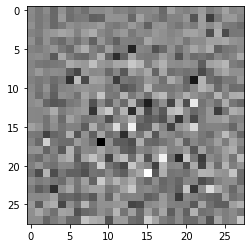

In [0]:
generator = generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [0]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [0]:
discriminator =discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.0013106]], shape=(1, 1), dtype=float32)


In [0]:
# This method returns a helper function to compute cross entropy loss
entropyerror = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminatorloss(real_output, fake_output):
    real_loss = entropyerror(tf.ones_like(real_output), real_output)
    fake_loss = entropyerror(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss
    

In [0]:
def generatorloss(fake_output):
    return entropyerror(tf.ones_like(fake_output), fake_output)

In [0]:
epochs = 700
testexamp= tf.random.normal([25, 100])
genoptimizer = tf.keras.optimizers.Adam(1e-4)
disoptimizer = tf.keras.optimizers.Adam(1e-4)

In [0]:

def trainbatch(realimages):
    noise = tf.random.normal([BATCH_SIZE, 100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(realimages, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generatorloss(fake_output)
      disc_loss = discriminatorloss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_weights)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_weights)

    genoptimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_weights))
    disoptimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_weights))


In [0]:
def totaltrain(epochs):
  for e in range(epochs):
    start = time.time()
    count=0
    progbar = tf.keras.utils.Progbar((len(trainy)/BATCH_SIZE)) #no.of batches
    for batch in trainx:
      trainbatch(batch)
      count+=1
      progbar.update(count)
    print(count)
    display.clear_output(wait=True)
    showandsave(generator,
                             e + 1,
                             testexamp)

    print ('Time for epoch {} is {} sec'.format(e + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  showandsave(generator,
                           e,
                           testexamp)
  print ('The generated images after final epoch ',epochs)

In [0]:
def showandsave(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(5,5))

  for i in range(predictions.shape[0]):
      plt.subplot(5, 5, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


In [0]:
totaltrain(epochs)

KeyboardInterrupt: ignored

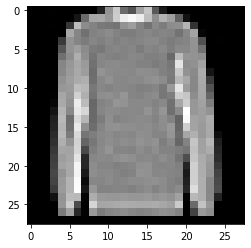

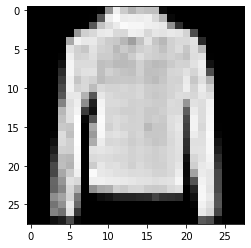

In [0]:
test_input=tf.random.normal([1,100])
generated_image = generator(test_input, training=False)

plt.imshow(x[45, :, :], cmap='gray')#original image
plt.show()
plt.imshow(generated_image[0, :, :,0], cmap='gray')

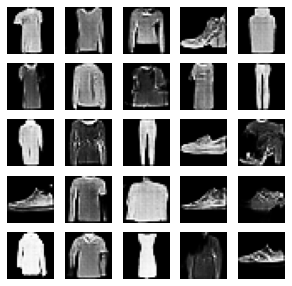

In [0]:
showandsave(generator,2,testexamp)

In [0]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [0]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 3*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [0]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)